# Init

In [1]:
## For google colab only
from google.colab import drive
drive.mount('/content/drive')
import sys, os
## on Phuc's drive
%cd /content/drive/MyDrive/Uni/Thesis/Repo 
os.chdir("/content/drive/MyDrive/Uni/Thesis/Repo")
!pip install ipython-autotime
%load_ext autotime

Mounted at /content/drive
/content/drive/MyDrive/Uni/Thesis/Repo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 
time: 551 µs (started: 2022-11-27 03:30:35 +00:00)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch, time, shutil, cv2, sys, os, json, torchvision
import torch.nn as nn
from skimage import io
import pandas as pd
from json import JSONEncoder
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm

time: 4.73 s (started: 2022-11-27 03:30:35 +00:00)


In [3]:
# Pano Json
pano_info = "/content/drive/MyDrive/Uni/Thesis/Repo/panos.json"
panoDict = dict()
with open(pano_info) as fp:
    panoDict = json.load(fp)
singleView = pd.read_json('/content/drive/MyDrive/Uni/Thesis/Repo/tree_F_Samples.json')
extraView = pd.read_json('/content/drive/MyDrive/Uni/Thesis/Repo/tree_EView_Samples.json')

time: 1min 10s (started: 2022-11-27 03:30:40 +00:00)


In [4]:
## Check point
# svCp =  singleView.copy()
# evCp = extraView.copy()

time: 544 µs (started: 2022-11-27 03:31:50 +00:00)


#Single view

In [5]:
singleView.describe()

,OBJECTID,lat,lng,cam_lat,cam_lng,distance,pxl_x,pxl_y,pxl_h,height
count,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,17795.000000,17795.000000
mean,36196.327303,34.155654,-118.131904,34.155654,-118.131910,9.202300,836.009510,516.948271,285.838944,1.238509
std,20547.082123,0.010603,0.012187,0.010604,0.012191,6.297270,432.714743,39.030318,260.181204,730.907797
min,1.000000,34.130307,-118.149597,34.130277,-118.149864,0.187038,2.299802,424.795055,1.000000,-61107.780779
25%,19855.000000,34.147535,-118.141706,34.147567,-118.141666,6.113222,415.777795,492.745194,14.000000,-3.014294
50%,33691.000000,34.157609,-118.134002,34.157628,-118.134035,7.565515,961.502388,515.979232,276.000000,4.095017
75%,51677.000000,34.164427,-118.124893,34.164464,-118.124909,10.061032,1249.233928,536.820323,528.000000,11.420933
max,82142.000000,34.171425,-118.106369,34.171453,-118.106283,90.301814,1663.746159,815.510078,817.000000,32228.348152


time: 60.3 ms (started: 2022-11-27 03:31:50 +00:00)


In [6]:
naCount = singleView["pxl_h"].isna().sum()
exPxlH = len(singleView[singleView['pxl_h'] >=626])
negHeight = len(singleView[singleView['height'] <=0])
exHeight = len(singleView[singleView['height'] >= 22])
lossingData = naCount + exPxlH + negHeight+ exHeight
print(f'Number of NA value: {naCount}')
print(f'Which is {naCount*100/len(singleView):.3f}% of dataset')
print(f'There are {exPxlH} trees have pixel height that nearly cover the image - {exPxlH*100/len(singleView):.3f}%')
print(f'There are {negHeight} trees have negative height (<=0) - {negHeight*100/len(singleView):.3f}%')
print(f'There are {exHeight} trees are higher than 22 meters) - {exHeight*100/len(singleView):.3f}%')
print(f'Data loss: {lossingData*100/len(singleView):.3f}% \n')

Number of NA value: 390
Which is 2.145% of dataset
There are 2195 trees have pixel height that nearly cover the image - 12.070%
There are 5962 trees have negative height (<=0) - 32.785%
There are 2248 trees are higher than 22 meters) - 12.362%
Data loss: 59.362% 

time: 13.8 ms (started: 2022-11-27 03:31:51 +00:00)


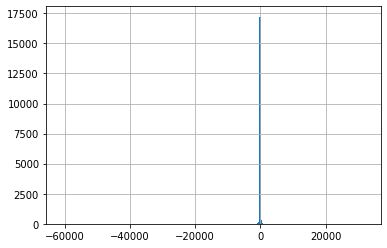

time: 591 ms (started: 2022-11-27 06:23:54 +00:00)


In [47]:
singleView['height'].hist(bins =250)

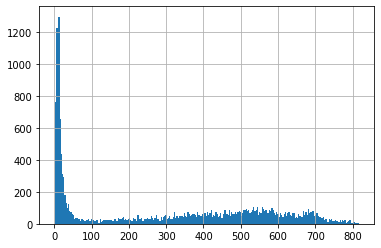

time: 662 ms (started: 2022-11-27 03:31:51 +00:00)


In [7]:
singleView['pxl_h'].hist(bins =250)

In [8]:
rangedSView = singleView.loc[(singleView['height'] < 22) & (singleView['height'] > 0) & (singleView['pxl_h'] <626)]
print(f'Data size: {len(rangedSView)}')

Data size: 7890
time: 8.44 ms (started: 2022-11-27 03:31:51 +00:00)


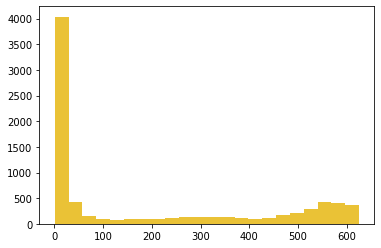

time: 203 ms (started: 2022-11-27 03:31:51 +00:00)


In [9]:
_ = plt.hist(rangedSView['pxl_h'], bins =22, color='#eac236')

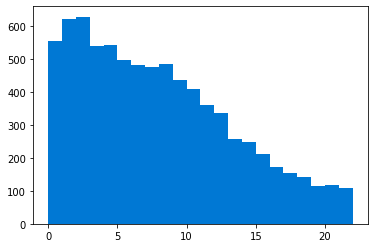

time: 264 ms (started: 2022-11-27 03:31:51 +00:00)


In [10]:
_ = plt.hist(rangedSView['height'], bins =22, color='#0078d4')

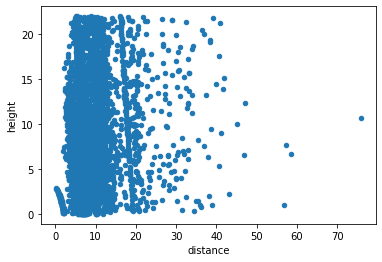

time: 255 ms (started: 2022-11-27 03:31:52 +00:00)


In [11]:
dst_height = singleView[['distance', 'height']]
dst_height = dst_height.loc[(dst_height['height'] < 22) & (dst_height['height'] > 0)]
ax = dst_height.plot.scatter(x='distance', y='height')

In [51]:
larger2 = dst_height.loc[dst_height['height'] >= 2]
print(f'Number of trees is higher than >= 2 meters: {len(larger2)} - {len(larger2)*100/len(singleView):.3f}%')

Number of trees is higher than >= 2 meters: 8234 - 45.279%
time: 7.9 ms (started: 2022-11-27 07:06:58 +00:00)


#Multiple views

In [12]:
mergeDf = pd.concat([singleView,extraView])
mergeDf.describe()

,OBJECTID,lat,lng,cam_lat,cam_lng,distance,pxl_x,pxl_y,pxl_h,height
count,55911.000000,55911.000000,55911.000000,55911.000000,55911.000000,55911.000000,55911.000000,55911.000000,54779.000000,5.477900e+04
mean,36169.789093,34.155653,-118.131902,34.155653,-15.375734,9.200114,831.499822,489.631269,299.485460,-1.161663e+03
std,20559.969896,0.010602,0.012191,0.010602,71.342463,6.322641,472.296658,33.323775,244.192209,2.765333e+05
min,1.000000,34.130307,-118.149597,34.130277,-118.149864,0.187037,0.027772,420.973811,1.000000,-6.468219e+07
25%,19839.000000,34.147502,-118.141718,34.147515,-118.119965,6.104539,411.851031,467.112053,19.000000,-7.730788e+00
50%,33687.000000,34.157618,-118.133985,34.157635,34.147841,7.560787,828.186418,482.123198,310.000000,3.427375e+00
75%,51626.000000,34.164419,-118.124936,34.164462,34.161505,10.059583,1249.627277,506.322148,511.000000,1.420783e+01
max,82142.000000,34.171425,-118.106369,34.171453,34.171453,90.301814,1663.967338,815.510078,817.000000,2.117978e+06


time: 97.6 ms (started: 2022-11-27 03:31:52 +00:00)


In [13]:
naCount = mergeDf["pxl_h"].isna().sum()
exPxlH = len(mergeDf[mergeDf['pxl_h'] >=626])
negHeight = len(mergeDf[mergeDf['height'] <=0])
exHeight = len(mergeDf[mergeDf['height'] >= 22])
print(f'Number of NA value: {naCount}')
print(f'Which is {naCount*100/len(mergeDf):.3f}% of dataset')
print(f'There are {exPxlH} data have pixel height that nearly cover the image - {exPxlH*100/len(mergeDf):.3f}%')
print(f'There are {negHeight} data have negative height (<=0) - {negHeight*100/len(mergeDf):.3f}%')
print(f'There are {exHeight} data are higher than 22 meters) - {exHeight*100/len(mergeDf):.3f}% \n')

Number of NA value: 1132
Which is 2.025% of dataset
There are 5951 data have pixel height that nearly cover the image - 10.644%
There are 21781 data have negative height (<=0) - 38.957%
There are 9557 data are higher than 22 meters) - 17.093% 

time: 16.7 ms (started: 2022-11-27 03:31:52 +00:00)


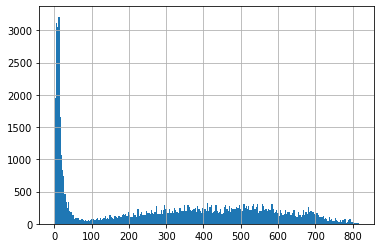

time: 596 ms (started: 2022-11-27 03:31:52 +00:00)


In [14]:
mergeDf['pxl_h'].hist(bins =250)

In [15]:
mRanged = mergeDf.loc[(mergeDf['height'] < 22) & (mergeDf['height'] > 0) & (mergeDf['pxl_h'] <626)]
print(f'Data size: {len(mRanged)}')

Data size: 20436
time: 10.8 ms (started: 2022-11-27 03:31:53 +00:00)


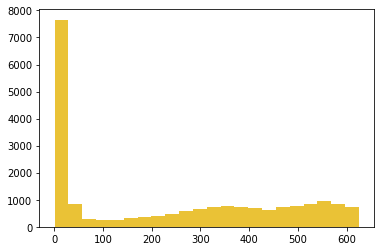

time: 239 ms (started: 2022-11-27 03:31:53 +00:00)


In [16]:
_ = plt.hist(mRanged['pxl_h'], bins =22, color='#eac236')

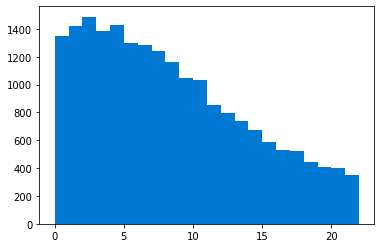

time: 197 ms (started: 2022-11-27 03:31:53 +00:00)


In [17]:
_ = plt.hist(mRanged['height'], bins =22, color='#0078d4')

## Merge views

In [18]:
## Preprocess extra df
extraData = extraView.dropna()
extraData = extraView.loc[(extraView['height'] < 22) & (extraView['height'] > 0) & (extraData['pxl_h'] <626)]
print(f'Extra data size: {len(extraData)}')

Extra data size: 12546
time: 44.9 ms (started: 2022-11-27 03:31:53 +00:00)


In [19]:
treesData = singleView[['OBJECTID','height']].to_numpy()
extraData = extraData[['OBJECTID','height']].to_numpy()

time: 5.48 ms (started: 2022-11-27 03:31:53 +00:00)


## Max update

In [20]:
## update height with multiview
## Filled empty rows with max height in extraView
maxHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extraData[extraData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    maxHFilled[maxHFilled[:,0] == id] = np.max(np.append(extraViewList[0][1],height))

time: 1.61 s (started: 2022-11-27 03:31:53 +00:00)


In [21]:
print(f'There are {len(naRows)} trees cant identify the height')
naAUpdated = len(maxHFilled[np.isnan(maxHFilled[:,1])])
print(f'{len(naRows) - naAUpdated} trees got updated')

There are 390 trees cant identify the height
0 trees got updated
time: 1.7 ms (started: 2022-11-27 03:31:55 +00:00)


In [22]:
maxHFilled = maxHFilled[(maxHFilled[:,1] < 22) & (maxHFilled[:,1] > 0)]
afterUpdated_Loss = len(treesData) - len(maxHFilled)
print(f'Workable data size after updated: {len(maxHFilled)} which is {len(maxHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

Workable data size after updated: 12777 which is 70.261% initial dataset.
Data loss: 29.739%.
5387 data is saved - 49.903% compared to inital loss 
.
time: 4.16 ms (started: 2022-11-27 03:31:55 +00:00)


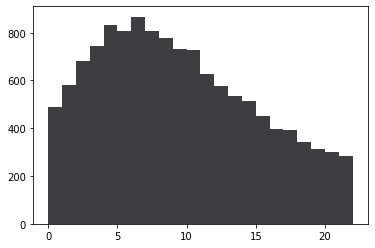

time: 183 ms (started: 2022-11-27 03:31:55 +00:00)


In [23]:
import matplotlib.pyplot as plt
_ = plt.hist(maxHFilled[:,1], bins=22, color ='#3e3d3f')

In [53]:
larger2 = maxHFilled[maxHFilled[:,1] >= 2]
print(f'Number of trees is higher than >= 2 meters: {len(larger2)} - {len(larger2)*100/len(singleView):.3f}%')

Number of trees is higher than >= 2 meters: 11706 - 64.372%
time: 5.16 ms (started: 2022-11-27 07:07:47 +00:00)


## Mean update

Workable data size after updated: 11566 which is 63.602% initial dataset.
Data loss: 36.398%.
4176 data is saved - 38.685% compared to inital loss 
.


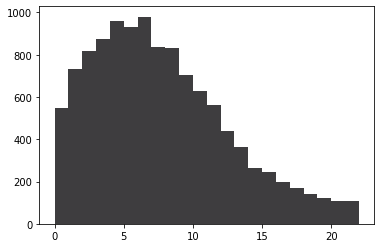

time: 1.85 s (started: 2022-11-27 03:31:55 +00:00)


In [24]:
## update height with multiview
## Filled empty rows with mean height in extraView
meanHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extraData[extraData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    meanHFilled[meanHFilled[:,0] == id] = np.mean(np.append(extraViewList[0][1],height))

meanHFilled = meanHFilled[(meanHFilled[:,1] < 22) & (meanHFilled[:,1] > 0)]

afterUpdated_Loss = len(treesData) - len(meanHFilled)
print(f'Workable data size after updated: {len(meanHFilled)} which is {len(meanHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

_ = plt.hist(meanHFilled[:,1], bins=22, color ='#3e3d3f')

In [54]:
larger2 = maxHFilled[maxHFilled[:,1] >= 2]
print(f'Number of trees is higher than >= 2 meters: {len(larger2)} - {len(larger2)*100/len(singleView):.3f}%')

Number of trees is higher than >= 2 meters: 11706 - 64.372%
time: 4.2 ms (started: 2022-11-27 07:08:00 +00:00)


## Median update

Workable data size after updated: 11566 which is 63.602% initial dataset.
Data loss: 36.398%.
4176 data is saved - 38.685% compared to inital loss 
.


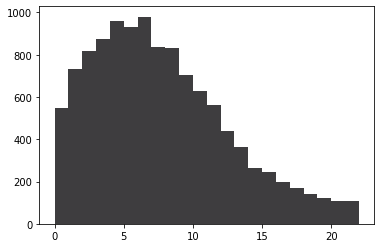

time: 2.15 s (started: 2022-11-27 03:31:57 +00:00)


In [25]:
## update height with multiview
## Filled empty rows with median height in extraView
medianHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extraData[extraData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    medianHFilled[medianHFilled[:,0] == id] = np.median(np.append(extraViewList[0][1],height))

medianHFilled = medianHFilled[(medianHFilled[:,1] < 22) & (medianHFilled[:,1] > 0)]

afterUpdated_Loss = len(treesData) - len(medianHFilled)
print(f'Workable data size after updated: {len(medianHFilled)} which is {len(medianHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

_ = plt.hist(medianHFilled[:,1], bins=22, color ='#3e3d3f')

In [55]:
larger2 = maxHFilled[maxHFilled[:,1] >= 2]
print(f'Number of trees is higher than >= 2 meters: {len(larger2)} - {len(larger2)*100/len(singleView):.3f}%')

Number of trees is higher than >= 2 meters: 11706 - 64.372%
time: 4.87 ms (started: 2022-11-27 07:08:04 +00:00)


#Multiple views - 2 Deep level

In [26]:
extraE2LView = pd.read_json('/content/drive/MyDrive/Uni/Thesis/Repo/tree_E2LView_Samples.json')

time: 1.36 s (started: 2022-11-27 06:00:17 +00:00)


In [27]:
mergeE2LDf = pd.concat([singleView,extraE2LView])
mergeE2LDf.describe()

,OBJECTID,lat,lng,cam_lat,cam_lng,distance,pxl_x,pxl_y,pxl_h,height
count,100427.000000,100427.000000,100427.000000,100427.000000,100427.000000,100427.000000,100427.000000,100427.000000,98441.000000,9.844100e+04
mean,36151.944816,34.155696,-118.131813,34.155696,6.579951,14.056001,829.456405,483.559140,297.758434,-1.293111e+03
std,20567.935403,0.010583,0.012230,0.010582,58.643482,9.573386,479.071848,29.090693,240.316703,2.917287e+05
min,1.000000,34.130307,-118.149597,34.130182,-118.149864,0.187038,0.027772,420.973811,1.000000,-6.468219e+07
25%,19819.000000,34.147549,-118.141717,34.147562,34.138140,9.581255,409.791042,465.236339,20.000000,-9.046978e+00
50%,33706.000000,34.157663,-118.133868,34.157714,34.154350,12.703222,813.990381,477.418003,306.000000,3.211606e+00
75%,51565.000000,34.164405,-118.124734,34.164456,34.163187,15.950140,1242.802049,496.361629,502.000000,1.510455e+01
max,82142.000000,34.171425,-118.106369,34.171557,34.171557,159.718195,1663.967338,815.510078,817.000000,2.117978e+06


time: 153 ms (started: 2022-11-27 06:00:57 +00:00)


In [33]:
naCount = mergeE2LDf["pxl_h"].isna().sum()
exPxlH = len(mergeE2LDf[mergeE2LDf['pxl_h'] >=626])
negHeight = len(mergeE2LDf[mergeE2LDf['height'] <=0])
exHeight = len(mergeE2LDf[mergeE2LDf['height'] >= 22])
print(f'Number of NA value: {naCount}')
print(f'Which is {naCount*100/len(mergeE2LDf):.3f}% of dataset')
print(f'There are {exPxlH} data have pixel height that nearly cover the image - {exPxlH*100/len(mergeDf):.3f}%')
print(f'There are {negHeight} data have negative height (<=0) - {negHeight*100/len(mergeE2LDf):.3f}%')
print(f'There are {exHeight} data are higher than 22 meters) - {exHeight*100/len(mergeE2LDf):.3f}% \n')

Number of NA value: 1986
Which is 1.978% of dataset
There are 10151 data have pixel height that nearly cover the image - 18.156%
There are 40469 data have negative height (<=0) - 40.297%
There are 18285 data are higher than 22 meters) - 18.207% 

time: 28 ms (started: 2022-11-27 06:02:17 +00:00)


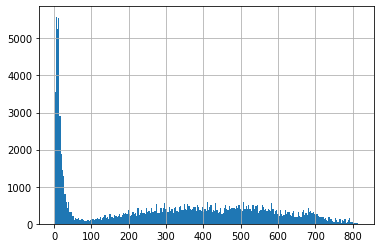

time: 620 ms (started: 2022-11-27 06:02:21 +00:00)


In [34]:
mergeE2LDf['pxl_h'].hist(bins =250)

In [35]:
mRanged = mergeE2LDf.loc[(mergeE2LDf['height'] < 22) & (mergeE2LDf['height'] > 0) & (mergeE2LDf['pxl_h'] <626)]
print(f'Data size: {len(mRanged)}')

Data size: 35259
time: 16.9 ms (started: 2022-11-27 06:02:30 +00:00)


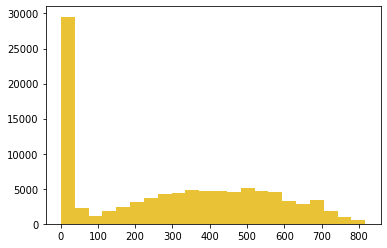

time: 331 ms (started: 2022-11-27 06:02:33 +00:00)


In [36]:
_ = plt.hist(mergeE2LDf['pxl_h'], bins =22, color='#eac236')

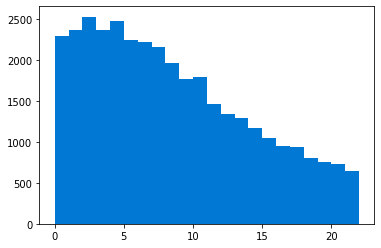

time: 196 ms (started: 2022-11-27 06:02:47 +00:00)


In [38]:
_ = plt.hist(mRanged['height'], bins =22, color='#0078d4')

## Merge views

In [39]:
## Preprocess extra df
extra2LData = extraE2LView.dropna()
extra2LData = extraE2LView.loc[(extraE2LView['height'] < 22) & (extraE2LView['height'] > 0) & (extraE2LView['pxl_h'] <626)]
print(f'Extra data size: {len(extra2LData)}')

Extra data size: 27369
time: 77.8 ms (started: 2022-11-27 06:04:00 +00:00)


In [40]:
treesData = singleView[['OBJECTID','height']].to_numpy()
extra2LData = extra2LData[['OBJECTID','height']].to_numpy()

time: 6.28 ms (started: 2022-11-27 06:04:11 +00:00)


## Max update

In [41]:
## update height with multiview
## Filled empty rows with max height in extraView
maxHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extra2LData[extra2LData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    maxHFilled[maxHFilled[:,0] == id] = np.max(np.append(extraViewList[0][1],height))

time: 2.82 s (started: 2022-11-27 06:05:07 +00:00)


In [42]:
print(f'There are {len(naRows)} trees cant identify the height')
naAUpdated = len(maxHFilled[np.isnan(maxHFilled[:,1])])
print(f'{len(naRows) - naAUpdated} trees got updated')

There are 390 trees cant identify the height
0 trees got updated
time: 3.77 ms (started: 2022-11-27 06:05:21 +00:00)


In [43]:
maxHFilled = maxHFilled[(maxHFilled[:,1] < 22) & (maxHFilled[:,1] > 0)]
afterUpdated_Loss = len(treesData) - len(maxHFilled)
print(f'Workable data size after updated: {len(maxHFilled)} which is {len(maxHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

Workable data size after updated: 12777 which is 70.261% initial dataset.
Data loss: 29.739%.
5387 data is saved - 49.903% compared to inital loss 
.
time: 3.85 ms (started: 2022-11-27 06:05:57 +00:00)


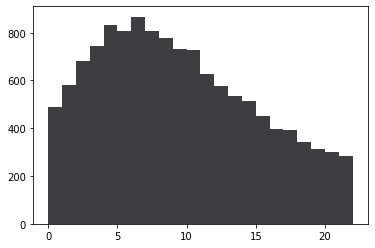

time: 178 ms (started: 2022-11-27 06:06:01 +00:00)


In [44]:
import matplotlib.pyplot as plt
_ = plt.hist(maxHFilled[:,1], bins=22, color ='#3e3d3f')

## Mean update

Workable data size after updated: 11566 which is 63.602% initial dataset.
Data loss: 36.398%.
4176 data is saved - 38.685% compared to inital loss 
.


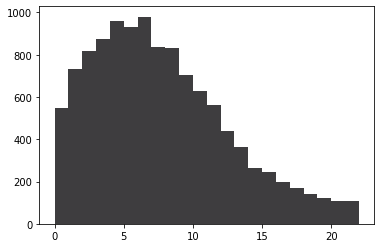

time: 2.34 s (started: 2022-11-27 06:09:20 +00:00)


In [45]:
## update height with multiview
## Filled empty rows with mean height in extraView
meanHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extra2LData[extra2LData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    meanHFilled[meanHFilled[:,0] == id] = np.mean(np.append(extraViewList[0][1],height))

meanHFilled = meanHFilled[(meanHFilled[:,1] < 22) & (meanHFilled[:,1] > 0)]

afterUpdated_Loss = len(treesData) - len(meanHFilled)
print(f'Workable data size after updated: {len(meanHFilled)} which is {len(meanHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

_ = plt.hist(meanHFilled[:,1], bins=22, color ='#3e3d3f')

## Median update

Workable data size after updated: 11566 which is 63.602% initial dataset.
Data loss: 36.398%.
4176 data is saved - 38.685% compared to inital loss 
.


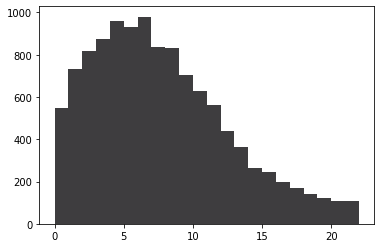

time: 2.76 s (started: 2022-11-27 06:09:27 +00:00)


In [46]:
## update height with multiview
## Filled empty rows with median height in extraView
medianHFilled = treesData.copy()
naRows = treesData[np.isnan(treesData[:,1])]
for tree in treesData:
  id, height = tree
  extraViewList = extra2LData[extra2LData[:,0] == id]
 
  if len(extraViewList) != 0:
    
    medianHFilled[medianHFilled[:,0] == id] = np.median(np.append(extraViewList[0][1],height))

medianHFilled = medianHFilled[(medianHFilled[:,1] < 22) & (medianHFilled[:,1] > 0)]

afterUpdated_Loss = len(treesData) - len(medianHFilled)
print(f'Workable data size after updated: {len(medianHFilled)} which is {len(medianHFilled)*100/len(treesData):.3f}% initial dataset.')
print(f'Data loss: {afterUpdated_Loss*100/len(singleView):.3f}%.')
print(f'{lossingData - afterUpdated_Loss} data is saved - {(lossingData - afterUpdated_Loss)*100/lossingData:.3f}% compared to inital loss \n.')

_ = plt.hist(medianHFilled[:,1], bins=22, color ='#3e3d3f')